In [14]:
# Imports
%matplotlib inline

import numpy as np
import cv2
import matplotlib.pyplot as plt
from math import sqrt

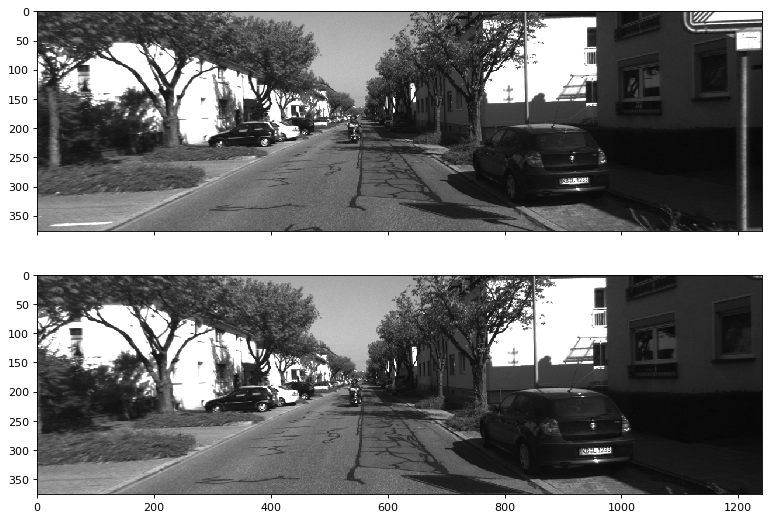

In [15]:
# KITTI Visual Odometry dataset sequence 00
folder = 'C:/Users/adamd/OneDrive/Documents/Stanford/Research/NAVLab/projects/UQ-optimization/data/KITTI/'
I1 = cv2.imread( folder + '000000.png')
I2 = cv2.imread( folder + '000001.png')

frame_idx = 0
frame_gap = 1

f, axarr = plt.subplots(2,1,sharex=True, figsize= (15,8), dpi= 80)
axarr[0].imshow(I1)
axarr[1].imshow(I2)

In [16]:
def readCameraMatrix(cameraFile):
      with open(cameraFile) as f:
          firstLine = f.readlines()[2][4:]
          focal, _, cx, _, _, _, cy, _, _, _, _, _ = list(map(float, firstLine.rstrip().split(" ")))

          K = np.zeros((3,3))
          K[0, 0] = focal
          K[0, 2] = cx
          K[1, 1] = focal
          K[1, 2] = cy
          K[2, 2] = 1
          return K

K = readCameraMatrix(folder + 'calib.txt')
K

array([[718.856 ,   0.    , 607.1928],
       [  0.    , 718.856 , 185.2157],
       [  0.    ,   0.    ,   1.    ]])

In [18]:
# Utility transform functions
def to_4x4(H):
  return np.vstack([H, np.array([0, 0, 0, 1])])

def to_H(R, T):
  return to_4x4(np.hstack([R, T.reshape((-1, 1))]))

def stable_inverse(H):
  R = H[:3, :3]
  T = H[:3, 3:4]
  H_inv = np.hstack([R.T, -R.T @ T])
  return to_4x4(H_inv)

def flatten_H(H):
  return H.reshape(-1)[:-4]

def print_compare(a, b, transform=False):
  if transform:
    a = flatten_H(a)
    b = flatten_H(b)
  print(list(zip(a, b)))

# Unit tests
def ut_1():
    H = np.hstack([np.eye(3), np.zeros((3, 1))])
    assert (to_4x4(H) == np.eye(4)).all()

def ut_2():
    H = np.hstack([np.eye(3), np.zeros((3, 1))])
    assert (stable_inverse(H) == np.eye(4)).all()

def ut_3():
    R = np.eye(3)
    T = np.zeros((3, 1))
    assert (to_H(R, T) == np.eye(4)).all()

# Run and debug
ut_1()
ut_2()
ut_3()

In [19]:
def readGroundtuthPosition(frame_idx, frame_gap, groundtruthFile = folder + "00.txt"):
  with open(groundtruthFile) as f:
    lines = f.readlines()
    
    H_curr = to_4x4(np.array(lines[frame_idx].rstrip().split(" "), dtype=np.float64).reshape((3, 4)))
    H_next = to_4x4(np.array(lines[frame_idx + frame_gap].rstrip().split(" "), dtype=np.float64).reshape((3, 4)))

    H_delta =  stable_inverse(H_curr) @ H_next 
        
  return H_delta, H_curr, H_next
      
# Run and debug
H_delta, H_curr, H_next = readGroundtuthPosition(frame_idx, frame_gap)

# Test whether the point H_next is same in world frame when coming from current frame reference
np.testing.assert_almost_equal(stable_inverse(stable_inverse(H_curr)) @ H_delta, H_next, decimal=4)

H_delta

array([[ 9.99997800e-01,  5.27262809e-04, -2.06693498e-03,
        -4.69029400e-02],
       [-5.29650590e-04,  9.99999200e-01, -1.15486476e-03,
        -2.83992798e-02],
       [ 2.06632382e-03,  1.15595812e-03,  9.99997000e-01,
         8.58694014e-01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])